mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0629A1'#
#########################

param.PRFX_B4 = 'Mel0627D1'; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0628B1'
param.ARCH = 'efficientnet-b1'
param.SZ = 224
param.EPOCHS = 100

# p2: efficientnet-b1 64
param.BS = 96

param.K=5; param.SEED=101; param.FLD2USE=0
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.LR=3e-3
param.WD=1e-3

param.N_SAMPL = None

param.DEBUG = True
if param.DEBUG: 
    param.EPOCHS = 5
    param.K = 5
    param.N_SAMPL = 2048

DEVICE = 'cuda'; PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0629A1',
 'PRFX_B4': 'Mel0627D1',
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0628B1',
 'ARCH': 'efficientnet-b1',
 'SZ': 224,
 'EPOCHS': 5,
 'BS': 64,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'LR': 0.003,
 'WD': 0.001,
 'N_SAMPL': 2048,
 'DEBUG': True}

In [2]:
!nvidia-smi

Mon Jun 29 18:15:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet

from apex import amp

def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../output/MelPrp0628B1/siim-isic-melanoma-clas...,IP_4021847,0.0
57432,19,../output/MelPrp0628B1/andrewmvd--isic-2019/IS...,BCN_0004730,1.0


(2048, 4)

20    1124
19     924
Name: source, dtype: int64

source
19    0.188312
20    0.017794
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

72


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 1638 410
1 1638 410
2 1638 410
3 1639 409
4 1639 409


0.0    0.899267
1.0    0.100733
Name: target, dtype: float64

0.0    0.909646
1.0    0.090354
Name: target, dtype: float64

0.0    0.905372
1.0    0.094628
Name: target, dtype: float64

0.0    0.90482
1.0    0.09518
Name: target, dtype: float64

0.0    0.907261
1.0    0.092739
Name: target, dtype: float64

20    889
19    749
Name: source, dtype: int64

20    912
19    726
Name: source, dtype: int64

20    894
19    744
Name: source, dtype: int64

20    902
19    737
Name: source, dtype: int64

20    899
19    740
Name: source, dtype: int64

# dataset

In [7]:
class MelDataset(Dataset):
    def __init__(self, df, istrn=True):
        self.df = df
        self.istrn = istrn
        self.composed = transforms.Compose([
            transforms.RandomResizedCrop(param.SZ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
    def __getitem__(self, i):
        x = Image.open(self.df.im_pth.values[i]) 
        x = self.composed(x)
        if self.istrn:
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

# model

In [8]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [9]:
# mdl = mkmdl()

# train

In [10]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## set up model

In [11]:
mdl = mkmdl()
mdl = mdl.to(device)

if param.PRFX_B4 is not None: 
    fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.FLD2USE_B4}_best.p'
    print('load previously trained', fnm_mdl_b4)
    mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))


# opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
mdl.zero_grad()


Loaded pretrained weights for efficientnet-b1
load previously trained ../output/Mel0627D1/model_Mel0627D1_fld_0_best.p


## set up data

In [12]:
tr,vl=fld2trvl[param.FLD2USE]
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
ystr=dftr.target.values
ysvl=dfvl.target.values
print(len(dftr), len(dfvl))
dstr = MelDataset(dftr)
dsvl = MelDataset(dfvl)
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl))
lendl=len(dltr)

1638 410
1638 410
26 4


## set up results

In [13]:
results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param

stats = {
    'lss': {'tr':[],'vl':[]},
    'scr': {'tr':[],'vl':[]},
}
oof = {'y':[], 'prd':[]}


def save_results():
    results['oof'] = oof
    stats['best_scr'] = best_scr
    stats['best_epc'] = best_epc
    results['stats'] = stats
    pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))

## run train

In [15]:
best_scr = float('-inf')
best_epc = -1
for epc in range(param.EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb = yb.unsqueeze(1)
        prdb = mdl(xb)
        loss = F.binary_cross_entropy_with_logits(prdb, yb)
        if param.FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if param.FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        opt.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    oof['y'].append(yvl_ep)
    oof['prd'].append(prdvl_ep)
    
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr = scr_vl_ep
        best_epc = epc
        torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p')
    if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_epc_{epc}.p')
        
    schdl.step(scr_vl_ep)  # Update learning rate schedule
    save_results()    
    

2020-06-29 18:17:52 ep 0 step 0/26
2020-06-29 18:18:01 ep 0: lss_tr 0.254; lss_vl 0.204; scr_tr 0.830; scr_vl 0.891; 
better scr -inf -> 0.891
2020-06-29 18:18:03 ep 1 step 0/26
2020-06-29 18:18:12 ep 1: lss_tr 0.251; lss_vl 0.194; scr_tr 0.830; scr_vl 0.878; 
2020-06-29 18:18:13 ep 2 step 0/26
2020-06-29 18:18:22 ep 2: lss_tr 0.250; lss_vl 0.221; scr_tr 0.831; scr_vl 0.879; 
2020-06-29 18:18:23 ep 3 step 0/26
2020-06-29 18:18:32 ep 3: lss_tr 0.249; lss_vl 0.188; scr_tr 0.840; scr_vl 0.889; 
2020-06-29 18:18:33 ep 4 step 0/26
2020-06-29 18:18:42 ep 4: lss_tr 0.255; lss_vl 0.232; scr_tr 0.830; scr_vl 0.885; 


## run done

In [16]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.8910


In [17]:
pd.DataFrame(stats['lss'])

,tr,vl
0,0.252432,0.226071
1,0.264393,0.193240
2,0.254438,0.203965
3,0.251324,0.193631
4,0.250252,0.221096
5,0.248657,0.188075
6,0.254919,0.232456


In [18]:
pd.DataFrame(stats['scr'])

,tr,vl
0,0.832959,0.821070
1,0.807836,0.906824
2,0.830278,0.890986
3,0.830381,0.877908
4,0.830842,0.879084
5,0.839758,0.888994
6,0.829725,0.885284


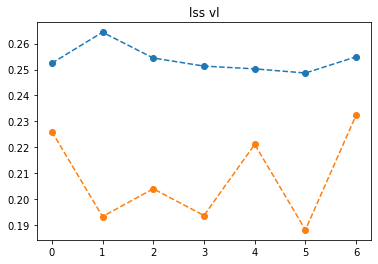

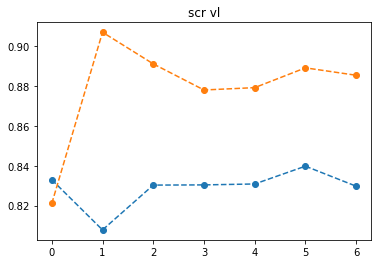

In [19]:
for mtrc in ['lss', 'scr']:
    recs=stats[mtrc]
    for tv,vs in recs.items():
        plt.title(f'{mtrc} {tv}')
        plt.plot(vs, 'o--')
    plt.show()

# inference

In [33]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, istrn=False)
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0628B1/siim-isic-melanoma-clas...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0628B1/siim-isic-melanoma-clas...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0628B1/siim-isic-melanoma-clas...


128
1


In [34]:
mdl = mkmdl()
fnm_mdl = f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p'
print('load model', fnm_mdl)
mdl.load_state_dict(torch.load(fnm_mdl, map_location=torch.device(DEVICE)))

mdl = mdl.to(device)

Loaded pretrained weights for efficientnet-b1
load model ../output/Mel0629A1/model_Mel0629A1_fld_0_best.p


In [35]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    return prd

In [36]:
prdtst = infer(mdl, dltst)

2020-06-29 18:22:37 step 0/1


In [37]:
dfsub.target = sigmoid(prdtst)
print(dfsub.target.mean())
dfsub.head()

0.06178373843431473


,image_name,target
0,ISIC_0052060,0.041540
1,ISIC_0052349,0.060975
2,ISIC_0058510,0.019234
3,ISIC_0073313,0.016403
4,ISIC_0073502,0.050799


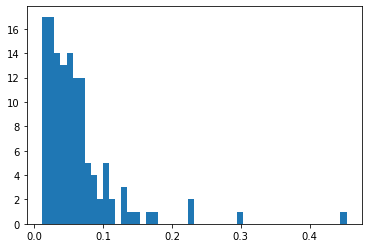

In [38]:
plt.hist(dfsub.target, bins=50);

In [39]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}.csv', index=False)

# fin

In [40]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.8910


In [41]:
param.__dict__

{'PRFX': 'Mel0629A1',
 'PRFX_B4': 'Mel0627D1',
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0628B1',
 'ARCH': 'efficientnet-b1',
 'SZ': 224,
 'EPOCHS': 5,
 'BS': 64,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'LR': 0.003,
 'WD': 0.001,
 'N_SAMPL': 2048,
 'DEBUG': True}

In [42]:
!nvidia-smi

Mon Jun 29 18:22:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    42W / 300W |   6726MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  